In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib
import mod_trace

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [3]:
result_dir = './Results'
create_folder(result_dir)

The folder already exists.


In [4]:
'''
O'Hara CiPA v1.0 2017
'''
cell_types = ['Endocardial', 'Epicardial', 'Mid-myocardial']

mmt_dir_path = "../../../mmt-model-files"

model = {}

model['ORD2011'] = {
    'mmt': "ord-2011.mmt",    
}
    
model['OHara2017'] = {
    'mmt' : "newordherg_qNet-v1.mmt",    
}

model['tenTusscher2004'] = {
    'mmt' : "tentusscher-2004.mmt",    
}

model['tenTusscher2006'] = {
    'mmt' : "tentusscher-2006.mmt",    
}

# model['Kernik2019'] = {
#     'mmt' : "kernik-2019.mmt",
# }

end_time = 500
bcl = 1000
duration = 0.5
offset = 20
# t_eval = np.linspace(0, end_time, 5000)  

In [5]:
import simulator_myokit
'''
Simulation with Myokit
'''
start_time = time.time()

protocol = myokit.pacing.blocktrain(bcl*100, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0

for model_name, info in model.items():      
    start = time.time()
    
    m, _, _ = myokit.load(os.path.join(mmt_dir_path, info['mmt']))
    s = simulator_myokit.Simulator(m, protocol, max_step=0.5, abs_tol=1e-08, rel_tol=1e-10, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10
    info['model'] = m
    info['sim'] = s
    
    print(f"{model_name} --- %s seconds ---"%(time.time()-start))

print("--- %s seconds ---"%(time.time()-start_time))

ORD2011 --- 6.943325996398926 seconds ---
OHara2017 --- 7.055829286575317 seconds ---
tenTusscher2004 --- 5.369608640670776 seconds ---
tenTusscher2006 --- 5.599636793136597 seconds ---
--- 24.968400716781616 seconds ---


In [6]:
'''
params for models
'''
cell_typeNo = 1
    
model['ORD2011']['params'] = {
    'cell.mode': cell_typeNo,    
}
model['OHara2017']['params'] = {
    'cell.mode': cell_typeNo,    
}
model['tenTusscher2004']['params'] = {
    'cell.type': cell_typeNo,    
}
model['tenTusscher2006']['params'] = {
    'cell.type': cell_typeNo,    
}

In [7]:
start_time = time.time()

for model_name, info in model.items():
    
    info['sim'].set_simulation_params(info['params'])    
    # Pre-pace and set a threshold value for APD measurements
    y0 = info['sim'].pre_simulate(bcl*100, sim_type=0)
    # Set the APD to 90% of the resting potential
    vt = 0.9 * info['sim'].simulation.state()[info['model'].get('membrane.V').indice()]
    # simulation
    d = info['sim'].simulate(end_time, log_times=None)
    # Calculate the APD
    apds = d.apd(threshold=vt, v='membrane.V')
    # The variable 'apds' now holds a dictionary with the keys 'start' and
    # 'duration', mapping to lists containing the values for each AP.
    print(apds)    
    info['time'] = d['engine.time']
    info['V'] = d['membrane.V']
    info['APD90'] = {
        'start': apds['start'][0],
        'duration': apds['duration'][0],
        'vt': vt
    }    
    print(f'APD90 for {model_name} = ' + str(apds['duration'][0]) + ' [ms]')
    print("-"*100)
print("--- %s seconds ---"%(time.time()-start_time))

DataLog([('start', [20.110947820637644]), ('duration', [269.630081330097])])
APD90 for ORD2011 = 269.630081330097 [ms]
----------------------------------------------------------------------------------------------------
DataLog([('start', [20.111514712734213]), ('duration', [255.4815846530302])])
APD90 for OHara2017 = 255.4815846530302 [ms]
----------------------------------------------------------------------------------------------------
DataLog([('start', [20.168855398599195]), ('duration', [305.7244497303415])])
APD90 for tenTusscher2004 = 305.7244497303415 [ms]
----------------------------------------------------------------------------------------------------
DataLog([('start', [20.168528908247303]), ('duration', [307.6515060309396])])
APD90 for tenTusscher2006 = 307.6515060309396 [ms]
----------------------------------------------------------------------------------------------------
--- 2.928666353225708 seconds ---


ORD2011
OHara2017
tenTusscher2004
tenTusscher2006


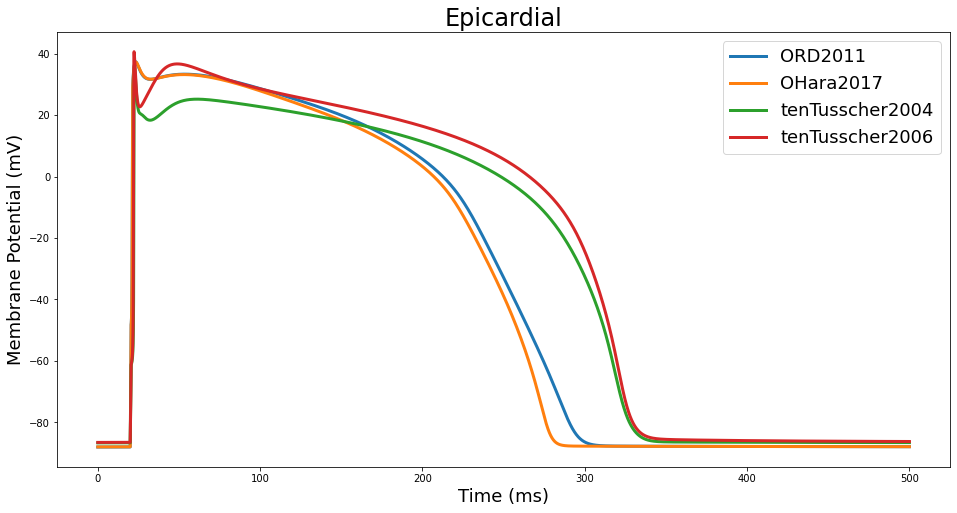

--- 0.37508392333984375 seconds ---


In [8]:
'''
Plot
'''
start_time = time.time()

fig, ax = plt.subplots(1,1, figsize=(16,8))    
for model_name, info in model.items():
    print(model_name)        
    # fig.suptitle(sim_ohara2017.name, fontsize=14)
    ax.set_title(cell_types[cell_typeNo], fontsize=24)
    # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Membrane Potential (mV)', fontsize=18)  
    ax.set_xlabel('Time (ms)', fontsize=18)       

    ax.plot( info['time'], info['V'], label=model_name, linewidth=3)         
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    ax.legend(fontsize=18)
    ax.grid()

plt.show()
fig.savefig(os.path.join(result_dir, f"AP-{cell_types[cell_typeNo]}.jpg"), dpi=300)    
print("--- %s seconds ---"%(time.time()-start_time))

ORD2011


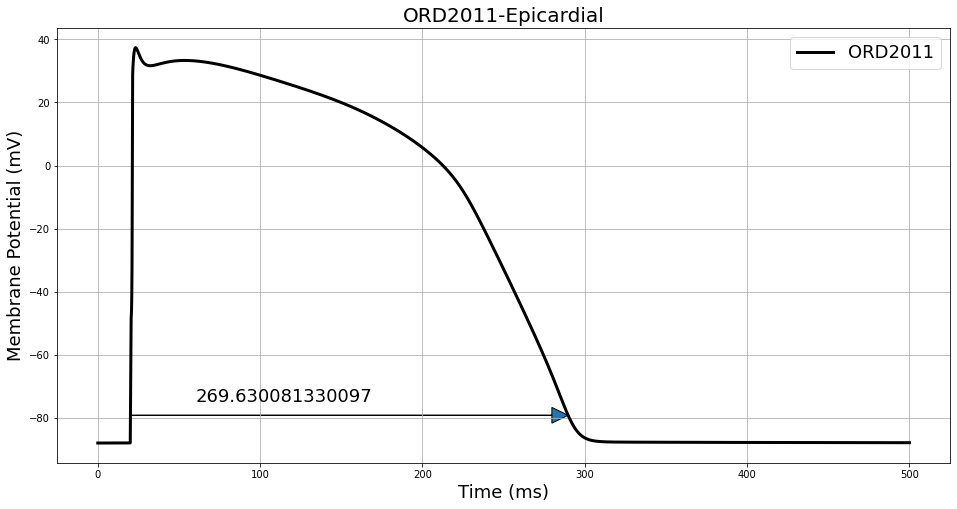

OHara2017


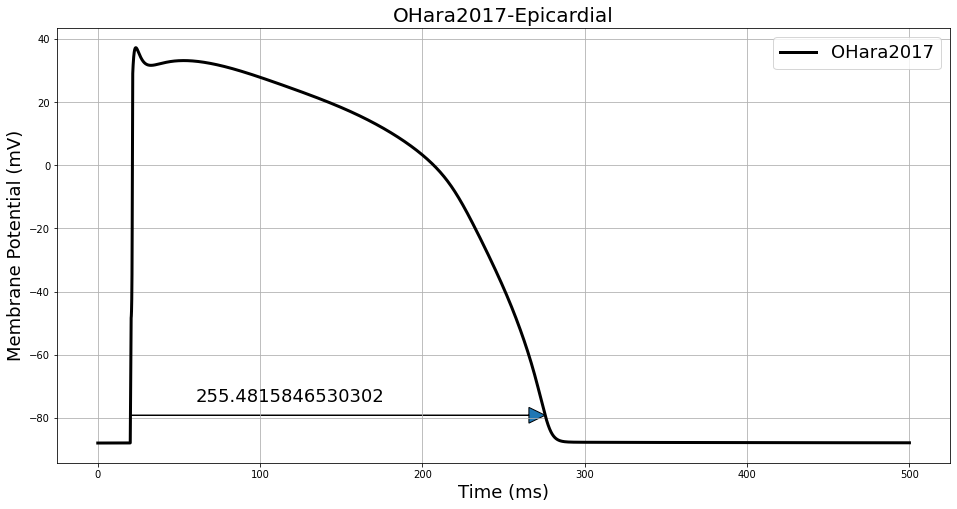

tenTusscher2004


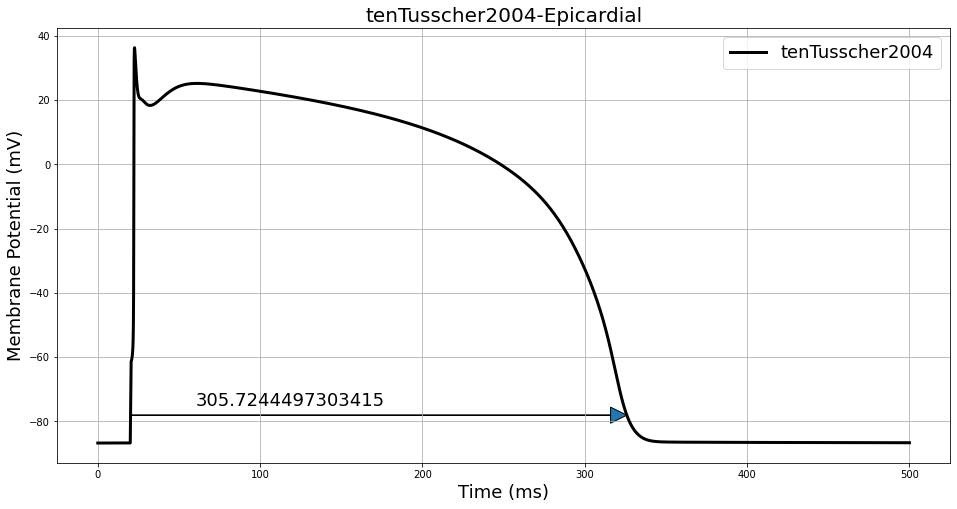

tenTusscher2006


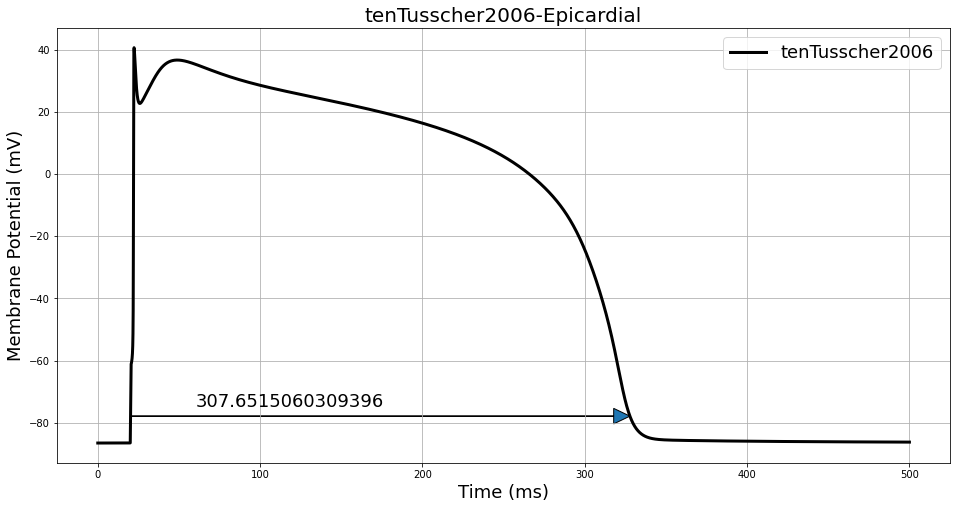

--- 1.3302888870239258 seconds ---


In [9]:
'''
Plot
'''
start_time = time.time()

for model_name, info in model.items():
    print(model_name)        
    apd90 = info['APD90']
    fig, ax = plt.subplots(1,1, figsize=(16,8))    
    # fig.suptitle(sim_ohara2017.name, fontsize=14)
    ax.set_title(f"{model_name}-{cell_types[cell_typeNo]}", fontsize=20)
    # ax.set_xlim(bdf_m.times.min(), bdf_m.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel('Membrane Potential (mV)', fontsize=18)  
    ax.set_xlabel('Time (ms)', fontsize=18)       

    ax.plot( info['time'], info['V'], label=model_name, linewidth=3, color='k')      
    ax.arrow(apd90['start'], apd90['vt'], apd90['duration'], 0, head_width=5, head_length=10, length_includes_head=True)
    ax.text(apd90['start']+40, -75, str(apd90['duration']), fontsize=18)
    # textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
    #             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    #     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
    #     fig1 = plt.gcf()
    ax.legend(fontsize=18)
    ax.grid()
    plt.show()
    fig.savefig(os.path.join(result_dir, f"{model_name}-{cell_types[cell_typeNo]}-APD90.jpg"), dpi=300)    
print("--- %s seconds ---"%(time.time()-start_time))

In [10]:
print("Complete")

Complete
